In [1]:
import time

import numpy as np
import tensorflow as tf
from keras.models import load_model

import cv2
import scipy.ndimage as ndimage
from skimage.draw import circle
from skimage.feature import peak_local_max

import rospy
from cv_bridge import CvBridge
from geometry_msgs.msg import PoseStamped
from sensor_msgs.msg import Image, CameraInfo
from std_msgs.msg import Float32MultiArray
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:

bridge = CvBridge()

# Load the Network.
MODEL_FILE = '/home/kinova16/catkin_ws/src/ggcnn_kinova_grasping/ggcnn_kinova_grasping/scripts/epoch_100_model.hdf5'
model = load_model(MODEL_FILE)

rospy.init_node('ggcnn_detection')

# Output publishers.
grasp_pub = rospy.Publisher('ggcnn/img/grasp', Image, queue_size=1)
grasp_plain_pub = rospy.Publisher('ggcnn/img/grasp_plain', Image, queue_size=1)
depth_pub = rospy.Publisher('ggcnn/img/depth', Image, queue_size=1)
ang_pub = rospy.Publisher('ggcnn/img/ang', Image, queue_size=1)
cmd_pub = rospy.Publisher('ggcnn/out/command', Float32MultiArray, queue_size=1)

# Initialise some globals.
prev_mp = np.array([150, 150])
ROBOT_Z = 0

# Tensorflow graph to allow use in callback.
graph = tf.get_default_graph()

# Get the camera parameters
camera_info_msg = rospy.wait_for_message('/camera/depth/camera_info', CameraInfo)
K = camera_info_msg.K
fx = K[0]
cx = K[2]
fy = K[4]
cy = K[5]

In [3]:
K

(384.3836669921875,
 0.0,
 317.1580505371094,
 0.0,
 384.3836669921875,
 246.2782745361328,
 0.0,
 0.0,
 1.0)

In [4]:
depth_message = rospy.wait_for_message('/camera/depth/image_meters', Image)
depth_message

header: 
  seq: 3981
  stamp: 
    secs: 1548404917
    nsecs: 516296849
  frame_id: "camera_depth_optical_frame"
height: 480
width: 640
encoding: "32FC1"
is_bigendian: 0
step: 2560
data: [0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 0, 0, 192, 127, 254, 212, 24, 63, 117, 147, 24, 63, 117, 147, 24, 63, 117, 147, 24, 63, 117, 147, 24, 63, 254, 212, 24, 63, 254, 212, 24, 63, 136, 22, 25, 63, 136, 22, 25,

In [5]:

def robot_pos_callback(data):
    global ROBOT_Z
    ROBOT_Z = data.pose.position.z

    
robot_pos_sub = rospy.Subscriber('/j2n6s300_driver/out/tool_pose', PoseStamped, robot_pos_callback, queue_size=1)


In [6]:
depth = bridge.imgmsg_to_cv2(depth_message)
# Crop a square out of the middle of the depth and resize it to 300*300
crop_size = 400
depth_crop = cv2.resize(depth[(480-crop_size)//2:(480-crop_size)//2+crop_size, (640-crop_size)//2:(640-crop_size)//2+crop_size], (300, 300))

# Replace nan with 0 for inpainting.
depth_crop = depth_crop.copy()
depth_nan = np.isnan(depth_crop).copy()
depth_crop[depth_nan] = 0

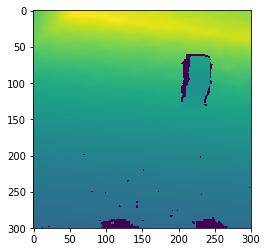

In [7]:
#cv2.imshow("Image", depth_crop) 
plt.imshow(depth_crop)

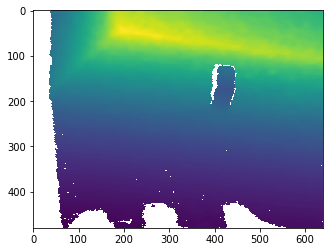

In [8]:
plt.imshow(depth)

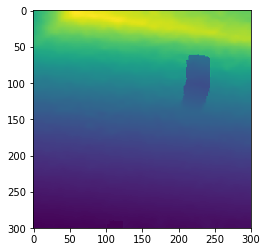

In [9]:
depth_crop = cv2.copyMakeBorder(depth_crop, 1, 1, 1, 1, cv2.BORDER_DEFAULT)

mask = (depth_crop == 0).astype(np.uint8)
# Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
depth_scale = np.abs(depth_crop).max()
depth_crop = depth_crop.astype(np.float32)/depth_scale  # Has to be float32, 64 not supported.

depth_crop = cv2.inpaint(depth_crop, mask, 1, cv2.INPAINT_NS)

# Back to original size and value range.
depth_crop = depth_crop[1:-1, 1:-1]
depth_crop = depth_crop * depth_scale
plt.imshow(depth_crop)

In [10]:
# Figure out roughly the depth in mm of the part between the grippers for collision avoidance.
depth_center = depth_crop[100:141, 130:171].flatten()
depth_center.sort()
depth_center = depth_center[:10].mean() * 1000.0
depth_center

562.4445080757141

In [11]:
# Run it through the network.
depth_crop = np.clip((depth_crop - depth_crop.mean()), -1, 1)
with graph.as_default():
    pred_out = model.predict(depth_crop.reshape((1, 300, 300, 1)))

points_out = pred_out[0].squeeze()
points_out[depth_nan] = 0

# Calculate the angle map.
cos_out = pred_out[1].squeeze()
sin_out = pred_out[2].squeeze()
ang_out = np.arctan2(sin_out, cos_out)/2.0

width_out = pred_out[3].squeeze() * 150.0

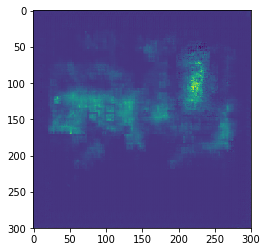

In [12]:
plt.imshow(width_out.reshape((300, 300)))

In [13]:
# Filter the outputs.
points_out = ndimage.filters.gaussian_filter(points_out, 5.0)  # 3.0
ang_out = ndimage.filters.gaussian_filter(ang_out, 2.0)

In [14]:
width_out.max()

95.3064

In [15]:
maxes = None

ALWAYS_MAX = False  # Use ALWAYS_MAX = True for the open-loop solution.

if ROBOT_Z > 0.34 or ALWAYS_MAX:  # > 0.34 initialises the max tracking when the robot is reset.
    # Track the global max.
    max_pixel = np.array(np.unravel_index(np.argmax(points_out), points_out.shape))
    prev_mp = max_pixel.astype(np.int)

In [16]:
# Calculate a set of local maxes.  Choose the one that is closes to the previous one.
maxes = peak_local_max(points_out, min_distance=10, threshold_abs=0.1, num_peaks=3)
max_pixel = maxes[np.argmin(np.linalg.norm(maxes - prev_mp, axis=1))]

# Keep a global copy for next iteration.
prev_mp = (max_pixel * 0.25 + prev_mp * 0.75).astype(np.int)
max_pixel


array([129, 127])

In [17]:
ang = ang_out[max_pixel[0], max_pixel[1]]
width = width_out[max_pixel[0], max_pixel[1]]

# Convert max_pixel back to uncropped/resized image coordinates in order to do the camera transform.
max_pixel = ((np.array(max_pixel) / 300.0 * crop_size) + np.array([(480 - crop_size)//2, (640 - crop_size) // 2]))
max_pixel = np.round(max_pixel).astype(np.int)
max_pixel

array([212, 289])

In [18]:
point_depth = depth[max_pixel[0], max_pixel[1]]
point_depth

0.588

In [19]:
x = (max_pixel[1] - cx)/(fx) * point_depth
y = (max_pixel[0] - cy)/(fy) * point_depth
z = point_depth

In [20]:
print(x, y,z)

(-0.04307397822584908, -0.05243621709688981, 0.588)


In [21]:
point_depth

0.588